# Tyre Quality Classification

## initialization variable

In [1]:
import os
import torch
import pathlib
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.nn import functional as F
import torchvision.models as models
torch.set_default_dtype(torch.float32)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 32 

## Loss Function

In [2]:
def cross_entropy(y_pred, y_true):
    ce_loss = nn.CrossEntropyLoss()(y_pred, y_true)
    return ce_loss

## Network model

A neural network with double convolution injection learning mechanism for binary classification problems

In [3]:
class ClassificationDigitalNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ClassificationDigitalNet, self).__init__()
        self.bc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)  
        )
        self.attention = nn.Sequential(
            nn.Linear(128 * 64 * 64, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 64 * 64, num_classes)
        )

    def forward(self, x):
        x = self.bc(x)
        x_flat = x.view(x.size(0), -1)
        attention_weights = self.attention(x_flat)
        x_attended = attention_weights.view(x.size(0), -1) * x_flat
        out = self.classifier(x_attended)
        return out

# The model is improved to an ensemble model

In [4]:
class ResidualBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, 2)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.normal_model = ClassificationDigitalNet(num_classes)
        self.residual_model = ResNet(num_classes)
        self.fc1 = nn.Linear(num_classes * 2, 512) 
        self.dropout1 = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(512, 256) 
        self.dropout2 = nn.Dropout(0.5)  
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        normal_output = self.normal_model(x)
        residual_output = self.residual_model(x)
        combined_output = torch.cat((normal_output, residual_output), dim=1)
        combined_output = self.fc1(combined_output)
        combined_output = nn.functional.relu(combined_output)
        combined_output = self.dropout1(combined_output)
        combined_output = self.fc2(combined_output)
        combined_output = nn.functional.relu(combined_output)
        combined_output = self.dropout2(combined_output)
        final_output = self.fc3(combined_output)
        return final_output

## 数据加载

In [5]:
class Digital(Dataset):  
    def __init__(self, path):
        super(Digital, self).__init__()
        data_root = pathlib.Path(path)
        all_image_paths = list(data_root.glob('*/*'))
        self.all_image_paths = [str(path) for path in all_image_paths]
        label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
        label_to_index = dict((label, index) for index, label in enumerate(label_names))
        print(label_to_index)
        self.all_image_labels = [label_to_index[path.parent.name] for path in all_image_paths]
        self.mean = np.array(mean).reshape((1, 1, 3))
        self.std = np.array(std).reshape((1, 1, 3))

    def __getitem__(self, index):
        img = cv.imread(self.all_image_paths[index])
        img = cv.resize(img, (256, 256))
        img = img / 255.
        img = (img - self.mean) / self.std
        img = np.transpose(img, [2, 0, 1])
        label = self.all_image_labels[index]
        img = torch.tensor(img, dtype=torch.float32)
        label = torch.tensor(label)
        return img, label

    def __len__(self):
        return len(self.all_image_paths)

In [6]:
data = Digital("./Digital images of defective and good condition tyres")
""" Splitting the dataset """
train_size = int(len(data) * 0.7)  # 训练集
vaild_size = int(len(data) * 0.15)  # 验证集
test_size = len(data) - train_size - vaild_size  # 测试集
train_dataset, vaild_dataset, test_dataset = random_split(data, [train_size, vaild_size, test_size],
                                                          generator=torch.Generator().manual_seed(0)) # 分割数据集
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
validate_loader = DataLoader(vaild_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

{'defective': 0, 'good': 1}


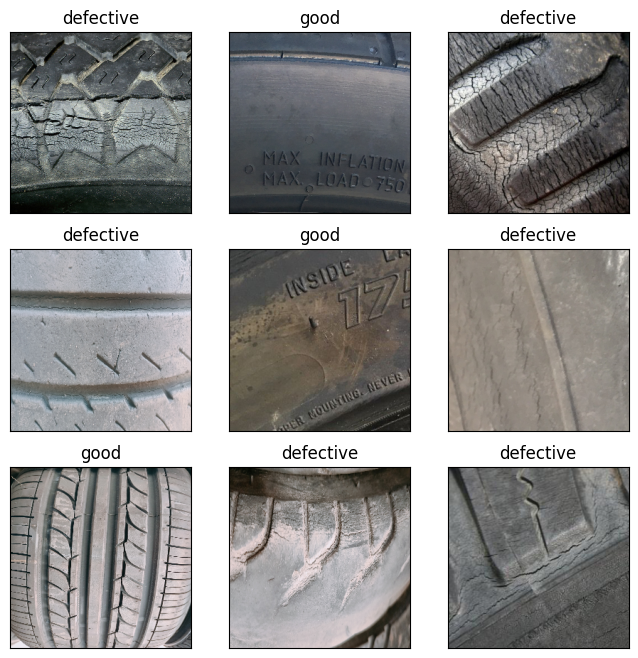

In [7]:
import random
from matplotlib import pyplot as plt


def denorm(img):
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    img = torch.clamp(img, 0., 1.)
    return img


plt.figure(figsize=(8, 8))
for i in range(9):
    img, label = train_dataset[random.randint(0, len(train_dataset))]
    img = denorm(img)
    img = img.permute(1, 2, 0)
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.numpy()[:, :, ::-1])
    ax.set_title(f"{'good' if label else  'defective'}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## network initialization

In [8]:
def score(y_pred, y_true):
    y_pred = y_pred.cpu().detach().numpy() if y_pred.is_cuda else y_pred.detach().numpy()
    y_true = y_true.cpu().detach().numpy() if y_true.is_cuda else y_true.detach().numpy()

    tp = (y_pred[(y_true == 1)]).sum()
    tn = (y_pred[(y_true == 0)]).sum()
    fp = ((y_pred == 1)[(y_true == 0)]).sum()
    fn = ((y_pred == 0)[(y_true == 1)]).sum()

    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else (tp + tn + fp + fn)
    pre = tp / (tp + fp) if (tp+fp) else (tp+fp)
    recall =  tp / (tp + fn) if (tp+fn) else (tp+fn)
    return acc, pre, recall

In [9]:
device = torch.device("cpu") 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
if device == "cuda:0":
    torch.cuda.set_per_process_memory_fraction(1.0)

In [10]:
"""Loading the model"""
PATH = "Digital.pth"
model = Net(2).to(device)
if os.path.exists(PATH):
    model.load_state_dict(torch.load(PATH))

In [11]:

from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)

model.train()
train_losses = []
train_precisions = []
train_recalls = []
train_accs = []


vail_accs = []
vail_losses = []

vail_precisions = []
vail_recalls = []


for epoch in range(10): 
    train_loss = []
    train_precision = []
    train_recall = []
    train_acc = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)  
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)  
        _, predicted = torch.max(outputs, 1)
        acc, precision, recall = score(predicted, labels)  

        train_acc.append(acc)  
        train_precision.append(precision) 
        train_recall.append(recall) 
        train_loss.append(loss.cpu().detach().numpy()) 
        loss.backward()
        optimizer.step()
        print("epoch:{}, batch:{}, loss:{}".format(epoch, i, loss))
    total = 0
    correct = 0
    
    vail_loss = []
    vail_precision = []
    vail_recall = []
    vail_acc = []
    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels) 
            _, predicted = torch.max(pred, 1)
            acc, precision, recall = score(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            vail_acc.append(acc)
            vail_precision.append(precision)
            vail_recall.append(recall)
            vail_loss.append(loss.cpu().detach().numpy())
        
        scheduler.step( sum(vail_loss) / len(vail_loss))

            
    print("batch:{},auc:{}%".format(total, correct / total * 100))
    train_losses.append(sum(train_loss) / len(train_loss))
    train_precisions.append(sum(train_precision) / len(train_precision))
    train_recalls.append(sum(train_recall) / len(train_recall))
    train_accs.append(sum(train_acc) / len(train_acc))
    
    vail_losses.append(sum(vail_loss) / len(vail_loss))
    vail_precisions.append(sum(vail_precision) / len(vail_precision))
    vail_recalls.append(sum(vail_recall) / len(vail_recall))
    vail_accs.append(sum(vail_acc) / len(vail_acc))

epoch:0, batch:0, loss:0.681760847568512
epoch:0, batch:1, loss:0.6886826157569885
epoch:0, batch:2, loss:0.6840295791625977
epoch:0, batch:3, loss:0.6876445412635803
epoch:0, batch:4, loss:0.723167896270752
epoch:0, batch:5, loss:0.7113435864448547
epoch:0, batch:6, loss:0.6782128810882568
epoch:0, batch:7, loss:0.7370890974998474
epoch:0, batch:8, loss:0.7064303159713745
epoch:0, batch:9, loss:0.7096754312515259
epoch:0, batch:10, loss:0.6704398393630981
epoch:0, batch:11, loss:0.7030377984046936
epoch:0, batch:12, loss:0.727540135383606
epoch:0, batch:13, loss:0.6954424381256104
epoch:0, batch:14, loss:0.7063378691673279
epoch:0, batch:15, loss:0.6980885863304138
epoch:0, batch:16, loss:0.7381013631820679
epoch:0, batch:17, loss:0.685762345790863
epoch:0, batch:18, loss:0.656240701675415
epoch:0, batch:19, loss:0.6855947971343994
epoch:0, batch:20, loss:0.6406419277191162
epoch:0, batch:21, loss:0.6752851605415344
epoch:0, batch:22, loss:0.6594567894935608
epoch:0, batch:23, loss:0.

In [12]:

model = ClassificationDigitalNet()

from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # 优化器

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)

model.train()
two_train_losses = []
two_train_precisions = []
two_train_recalls = []
two_train_accs = []


two_vail_accs = []
two_vail_losses = []

two_vail_precisions = []
two_vail_recalls = []


for epoch in range(10): 
    two_train_loss = []
    two_train_precision = []
    two_train_recall = []
    two_train_acc = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)  
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)  
        _, predicted = torch.max(outputs, 1)
        acc, precision, recall = score(predicted, labels)  

        two_train_acc.append(acc)  
        two_train_precision.append(precision) 
        two_train_recall.append(recall) 
        two_train_loss.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        print("epoch:{}, batch:{}, loss:{}".format(epoch, i, loss))
    total = 0
    correct = 0
    
    two_vail_loss = []
    two_vail_precision = []
    two_vail_recall = []
    two_vail_acc = []
    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels)  
            _, predicted = torch.max(pred, 1)
            acc, precision, recall = score(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            two_vail_acc.append(acc)
            two_vail_precision.append(precision)
            two_vail_recall.append(recall)
            two_vail_loss.append(loss.cpu().detach().numpy())
        
        scheduler.step( sum(two_vail_loss) / len(two_vail_loss))

            
    print("batch:{},auc:{}%".format(total, correct / total * 100))
    two_train_losses.append(sum(two_train_loss) / len(two_train_loss))
    two_train_precisions.append(sum(two_train_precision) / len(two_train_precision))
    two_train_recalls.append(sum(two_train_recall) / len(two_train_recall))
    two_train_accs.append(sum(two_train_acc) / len(two_train_acc))
    
    two_vail_losses.append(sum(two_vail_loss) / len(two_vail_loss))
    two_vail_precisions.append(sum(two_vail_precision) / len(two_vail_precision))
    two_vail_recalls.append(sum(two_vail_recall) / len(two_vail_recall))
    two_vail_accs.append(sum(two_vail_acc) / len(two_vail_acc))

epoch:0, batch:0, loss:0.6932275295257568
epoch:0, batch:1, loss:0.6919553279876709
epoch:0, batch:2, loss:0.6871511936187744
epoch:0, batch:3, loss:0.6812012791633606
epoch:0, batch:4, loss:0.5830063223838806
epoch:0, batch:5, loss:0.6927148699760437
epoch:0, batch:6, loss:0.7249343395233154
epoch:0, batch:7, loss:0.743848979473114
epoch:0, batch:8, loss:0.5804885625839233
epoch:0, batch:9, loss:0.617655873298645
epoch:0, batch:10, loss:0.6599984169006348
epoch:0, batch:11, loss:0.6208677291870117
epoch:0, batch:12, loss:0.8259137868881226
epoch:0, batch:13, loss:0.6491802334785461
epoch:0, batch:14, loss:0.675415575504303
epoch:0, batch:15, loss:0.6719327569007874
epoch:0, batch:16, loss:0.7062388062477112
epoch:0, batch:17, loss:0.659412145614624
epoch:0, batch:18, loss:0.6529927253723145
epoch:0, batch:19, loss:0.5810751914978027
epoch:0, batch:20, loss:0.6115319728851318
epoch:0, batch:21, loss:0.8330765962600708
epoch:0, batch:22, loss:0.7144169807434082
epoch:0, batch:23, loss:0

In [13]:
# resNet

model = ResNet()
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # 优化器

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)

model.train()
res_train_losses = []
res_train_precisions = []
res_train_recalls = []
res_train_accs = []


res_vail_accs = []
res_vail_losses = []

res_vail_precisions = []
res_vail_recalls = []


for epoch in range(10): 
    res_train_loss = []
    res_train_precision = []
    res_train_recall = []
    res_train_acc = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)  
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)  
        _, predicted = torch.max(outputs, 1)
        acc, precision, recall = score(predicted, labels)  

        res_train_acc.append(acc)  
        res_train_precision.append(precision) 
        res_train_recall.append(recall) 
        res_train_loss.append(loss.cpu().detach().numpy()) 
        loss.backward()
        optimizer.step()
        print("epoch:{}, batch:{}, loss:{}".format(epoch, i, loss))
    total = 0
    correct = 0
    
    res_vail_loss = []
    res_vail_precision = []
    res_vail_recall = []
    res_vail_acc = []
    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels)  
            _, predicted = torch.max(pred, 1)
            acc, precision, recall = score(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            res_vail_acc.append(acc)
            res_vail_precision.append(precision)
            res_vail_recall.append(recall)
            res_vail_loss.append(loss.cpu().detach().numpy())
        
        scheduler.step( sum(res_vail_loss) / len(res_vail_loss))

            
    print("batch:{},auc:{}%".format(total, correct / total * 100))
    res_train_losses.append(sum(res_train_loss) / len(res_train_loss))
    res_train_precisions.append(sum(res_train_precision) / len(res_train_precision))
    res_train_recalls.append(sum(res_train_recall) / len(res_train_recall))
    res_train_accs.append(sum(res_train_acc) / len(res_train_acc))
    
    res_vail_losses.append(sum(res_vail_loss) / len(res_vail_loss))
    res_vail_precisions.append(sum(res_vail_precision) / len(res_vail_precision))
    res_vail_recalls.append(sum(res_vail_recall) / len(res_vail_recall))
    res_vail_accs.append(sum(res_vail_acc) / len(res_vail_acc))

epoch:0, batch:0, loss:0.9834886789321899
epoch:0, batch:1, loss:0.9007129669189453
epoch:0, batch:2, loss:0.8160906434059143
epoch:0, batch:3, loss:0.7230585217475891
epoch:0, batch:4, loss:0.7453650236129761
epoch:0, batch:5, loss:0.7524653673171997
epoch:0, batch:6, loss:0.7913609743118286
epoch:0, batch:7, loss:0.8049834370613098
epoch:0, batch:8, loss:0.6952567100524902
epoch:0, batch:9, loss:0.7183394432067871
epoch:0, batch:10, loss:0.6903145909309387
epoch:0, batch:11, loss:0.5641486644744873
epoch:0, batch:12, loss:0.8755293488502502
epoch:0, batch:13, loss:0.7192040681838989
epoch:0, batch:14, loss:0.5888773798942566
epoch:0, batch:15, loss:0.833954930305481
epoch:0, batch:16, loss:0.6455284357070923
epoch:0, batch:17, loss:0.6442738175392151
epoch:0, batch:18, loss:0.762646496295929
epoch:0, batch:19, loss:0.535993754863739
epoch:0, batch:20, loss:0.705283522605896
epoch:0, batch:21, loss:0.637657880783081
epoch:0, batch:22, loss:0.6151785850524902
epoch:0, batch:23, loss:0.

In [14]:
import torch
import torchvision.models as models
from torchvision.models import resnet50
model_resnet50 = models.resnet50(pretrained=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)


model_resnet50 = resnet50(pretrained=True)
optimizer_resnet50 = torch.optim.SGD(model_resnet50.parameters(), lr=0.001, momentum=0.9)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)

model.train()
res50_train_losses = []
res50_train_precisions = []
res50_train_recalls = []
res50_train_accs = []


res50_vail_accs = []
res50_vail_losses = []

res50_vail_precisions = []
res50_vail_recalls = []


for epoch in range(10): 
    res50_train_loss = []
    res50_train_precision = []
    res50_train_recall = []
    res50_train_acc = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)  
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)  
        _, predicted = torch.max(outputs, 1)
        acc, precision, recall = score(predicted, labels)  

        res50_train_acc.append(acc)  
        res50_train_precision.append(precision) 
        res50_train_recall.append(recall) 
        res50_train_loss.append(loss.cpu().detach().numpy()) 
        loss.backward()
        optimizer.step()
        print("epoch:{}, batch:{}, loss:{}".format(epoch, i, loss))
    total = 0
    correct = 0
    
    res50_vail_loss = []
    res50_vail_precision = []
    res50_vail_recall = []
    res50_vail_acc = []
    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels)  
            _, predicted = torch.max(pred, 1)
            acc, precision, recall = score(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            res50_vail_acc.append(acc)
            res50_vail_precision.append(precision)
            res50_vail_recall.append(recall)
            res50_vail_loss.append(loss.cpu().detach().numpy())
        
        scheduler.step( sum(res50_vail_loss) / len(res50_vail_loss))

            
    print("batch:{},auc:{}%".format(total, correct / total * 100))
    res50_train_losses.append(sum(res50_train_loss) / len(res50_train_loss))
    res50_train_precisions.append(sum(res50_train_precision) / len(res50_train_precision))
    res50_train_recalls.append(sum(res50_train_recall) / len(res50_train_recall))
    res50_train_accs.append(sum(res50_train_acc) / len(res50_train_acc))
    
    res50_vail_losses.append(sum(res50_vail_loss) / len(res50_vail_loss))
    res50_vail_precisions.append(sum(res50_vail_precision) / len(res50_vail_precision))
    res50_vail_recalls.append(sum(res50_vail_recall) / len(res50_vail_recall))
    res50_vail_accs.append(sum(res50_vail_acc) / len(res50_vail_acc))

/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch:0, batch:0, loss:0.10764828324317932
epoch:0, batch:1, loss:0.16582466661930084
epoch:0, batch:2, loss:0.22915585339069366
epoch:0, batch:3, loss:0.24455122649669647
epoch:0, batch:4, loss:0.0814284086227417
epoch:0, batch:5, loss:0.227188378572464
epoch:0, batch:6, loss:0.10841082781553268
epoch:0, batch:7, loss:0.09360715746879578
epoch:0, batch:8, loss:0.1678028553724289
epoch:0, batch:9, loss:0.25831523537635803
epoch:0, batch:10, loss:0.12941095232963562
epoch:0, batch:11, loss:0.07600689679384232
epoch:0, batch:12, loss:0.15222984552383423
epoch:0, batch:13, loss:0.1499633491039276
epoch:0, batch:14, loss:0.18837828934192657
epoch:0, batch:15, loss:0.20043672621250153
epoch:0, batch:16, loss:0.14780837297439575
epoch:0, batch:17, loss:0.1030820831656456
epoch:0, batch:18, loss:0.17610561847686768
epoch:0, batch:19, loss:0.1357678920030594
epoch:0, batch:20, loss:0.10609250515699387
epoch:0, batch:21, loss:0.10388132929801941
epoch:0, batch:22, loss:0.12939755618572235
epoch

In [15]:
import torch
import torchvision.models as models

model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
optimizer_mobilenet_v2 = torch.optim.SGD(model_mobilenet_v2.parameters(), lr=0.001, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)

model.train()
v2_train_losses = []
v2_train_precisions = []
v2_train_recalls = []
v2_train_accs = []


v2_vail_accs = []
v2_vail_losses = []

v2_vail_precisions = []
v2_vail_recalls = []


for epoch in range(10): 
    v2_train_loss = []
    v2_train_precision = []
    v2_train_recall = []
    v2_train_acc = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)  
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)  
        _, predicted = torch.max(outputs, 1)
        acc, precision, recall = score(predicted, labels)  

        v2_train_acc.append(acc)  
        v2_train_precision.append(precision) 
        v2_train_recall.append(recall) 
        v2_train_loss.append(loss.cpu().detach().numpy()) 
        loss.backward()
        optimizer.step()
        print("epoch:{}, batch:{}, loss:{}".format(epoch, i, loss))
    total = 0
    correct = 0
    
    v2_vail_loss = []
    v2_vail_precision = []
    v2_vail_recall = []
    v2_vail_acc = []
    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels) 
            _, predicted = torch.max(pred, 1)
            acc, precision, recall = score(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            v2_vail_acc.append(acc)
            v2_vail_precision.append(precision)
            v2_vail_recall.append(recall)
            v2_vail_loss.append(loss.cpu().detach().numpy())
        
        scheduler.step( sum(v2_vail_loss) / len(v2_vail_loss))

            
    print("batch:{},auc:{}%".format(total, correct / total * 100))
    v2_train_losses.append(sum(v2_train_loss) / len(v2_train_loss))
    v2_train_precisions.append(sum(v2_train_precision) / len(v2_train_precision))
    v2_train_recalls.append(sum(v2_train_recall) / len(v2_train_recall))
    v2_train_accs.append(sum(v2_train_acc) / len(v2_train_acc))
    
    v2_vail_losses.append(sum(v2_vail_loss) / len(v2_vail_loss))
    v2_vail_precisions.append(sum(v2_vail_precision) / len(v2_vail_precision))
    v2_vail_recalls.append(sum(v2_vail_recall) / len(v2_vail_recall))
    v2_vail_accs.append(sum(v2_vail_acc) / len(v2_vail_acc))

/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch:0, batch:0, loss:0.01441953144967556
epoch:0, batch:1, loss:0.01902233436703682
epoch:0, batch:2, loss:0.05661939084529877
epoch:0, batch:3, loss:0.029906021431088448
epoch:0, batch:4, loss:0.02823265641927719
epoch:0, batch:5, loss:0.04290217533707619
epoch:0, batch:6, loss:0.02524869702756405
epoch:0, batch:7, loss:0.014184345491230488
epoch:0, batch:8, loss:0.07242421805858612
epoch:0, batch:9, loss:0.018792403861880302
epoch:0, batch:10, loss:0.020210133865475655
epoch:0, batch:11, loss:0.016405923292040825
epoch:0, batch:12, loss:0.055763568729162216
epoch:0, batch:13, loss:0.025390800088644028
epoch:0, batch:14, loss:0.019967159256339073
epoch:0, batch:15, loss:0.06954365968704224
epoch:0, batch:16, loss:0.04717979580163956
epoch:0, batch:17, loss:0.03844691067934036
epoch:0, batch:18, loss:0.028622640296816826
epoch:0, batch:19, loss:0.07992743700742722
epoch:0, batch:20, loss:0.017438586801290512
epoch:0, batch:21, loss:0.023726224899291992
epoch:0, batch:22, loss:0.06302

In [16]:
from torchvision.models import vgg16
import torch


model_vgg16 = vgg16(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

optimizer_vgg16 = torch.optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)

model.train()
vgg16_train_losses = []
vgg16_train_precisions = []
vgg16_train_recalls = []
vgg16_train_accs = []


vgg16_vail_accs = []
vgg16_vail_losses = []

vgg16_vail_precisions = []
vgg16_vail_recalls = []


for epoch in range(10): 
    vgg16_train_loss = []
    vgg16_train_precision = []
    vgg16_train_recall = []
    vgg16_train_acc = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)  
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)  
        _, predicted = torch.max(outputs, 1)
        acc, precision, recall = score(predicted, labels)  

        vgg16_train_acc.append(acc)  
        vgg16_train_precision.append(precision) 
        vgg16_train_recall.append(recall) 
        vgg16_train_loss.append(loss.cpu().detach().numpy()) 
        loss.backward()
        optimizer.step()
        print("epoch:{}, batch:{}, loss:{}".format(epoch, i, loss))
    total = 0
    correct = 0
    
    vgg16_vail_loss = []
    vgg16_vail_precision = []
    vgg16_vail_recall = []
    vgg16_vail_acc = []
    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels)  
            _, predicted = torch.max(pred, 1)
            acc, precision, recall = score(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            vgg16_vail_acc.append(acc)
            vgg16_vail_precision.append(precision)
            vgg16_vail_recall.append(recall)
            vgg16_vail_loss.append(loss.cpu().detach().numpy())
        
        scheduler.step( sum(vgg16_vail_loss) / len(vgg16_vail_loss))

            
    print("batch:{},auc:{}%".format(total, correct / total * 100))
    vgg16_train_losses.append(sum(vgg16_train_loss) / len(vgg16_train_loss))
    vgg16_train_precisions.append(sum(vgg16_train_precision) / len(vgg16_train_precision))
    vgg16_train_recalls.append(sum(vgg16_train_recall) / len(vgg16_train_recall))
    vgg16_train_accs.append(sum(vgg16_train_acc) / len(vgg16_train_acc))
    
    vgg16_vail_losses.append(sum(vgg16_vail_loss) / len(vgg16_vail_loss))
    vgg16_vail_precisions.append(sum(vgg16_vail_precision) / len(vgg16_vail_precision))
    vgg16_vail_recalls.append(sum(vgg16_vail_recall) / len(vgg16_vail_recall))
    vgg16_vail_accs.append(sum(vgg16_vail_acc) / len(vgg16_vail_acc))

/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch:0, batch:0, loss:0.006909877993166447
epoch:0, batch:1, loss:0.009008865803480148
epoch:0, batch:2, loss:0.029044274240732193
epoch:0, batch:3, loss:0.015990441665053368
epoch:0, batch:4, loss:0.013994147069752216
epoch:0, batch:5, loss:0.021349381655454636
epoch:0, batch:6, loss:0.013214501552283764
epoch:0, batch:7, loss:0.008068116381764412
epoch:0, batch:8, loss:0.05350330471992493
epoch:0, batch:9, loss:0.012193664908409119
epoch:0, batch:10, loss:0.01473982073366642
epoch:0, batch:11, loss:0.011142073199152946
epoch:0, batch:12, loss:0.019572481513023376
epoch:0, batch:13, loss:0.006774730980396271
epoch:0, batch:14, loss:0.016913460567593575
epoch:0, batch:15, loss:0.04264809563755989
epoch:0, batch:16, loss:0.017728488892316818
epoch:0, batch:17, loss:0.012986293062567711
epoch:0, batch:18, loss:0.010093082673847675
epoch:0, batch:19, loss:0.049868229776620865
epoch:0, batch:20, loss:0.009452716447412968
epoch:0, batch:21, loss:0.013133501634001732
epoch:0, batch:22, loss

In [17]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-4.6234e-02,  1.0932e-02,  5.1853e-02,  ...,  8.0666e-02,
                          1.7536e-02, -2.3031e-02],
                        [ 6.9351e-02, -6.2109e-03,  7.6965e-02,  ..., -7.9595e-02,
                          3.1274e-02,  3.5044e-02],
                        [-2.1243e-02,  4.6281e-02,  6.8494e-02,  ..., -6.3771e-02,
                          3.4416e-02, -6.3165e-02],
                        ...,
                        [ 6.5273e-02,  6.3415e-02,  2.0661e-02,  ...,  2.7990e-02,
                         -1.0472e-02, -3.3448e-02],
                        [-4.0951e-02,  8.0289e-02, -1.5654e-02,  ..., -1.9996e-02,
                         -1.3616e-02,  6.4012e-02],
                        [-7.2381e-02, -7.7122e-02, -3.5933e-03,  ..., -4.6742e-02,
                          5.3592e-02, -3.3265e-02]],
              
                       [[-1.0114e-02, -5.1818e-02,  4.0593e-02,  ...,  5.3255e-02,
                         -4.5855

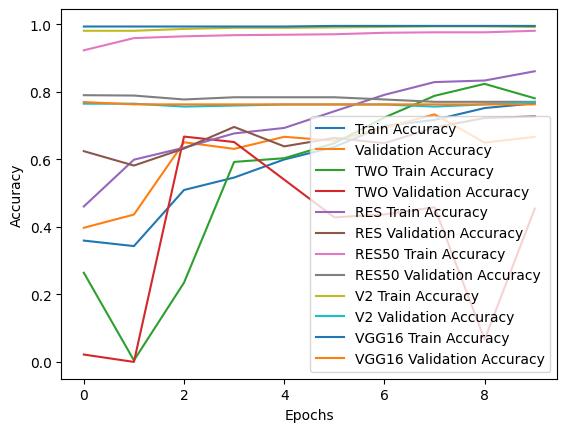

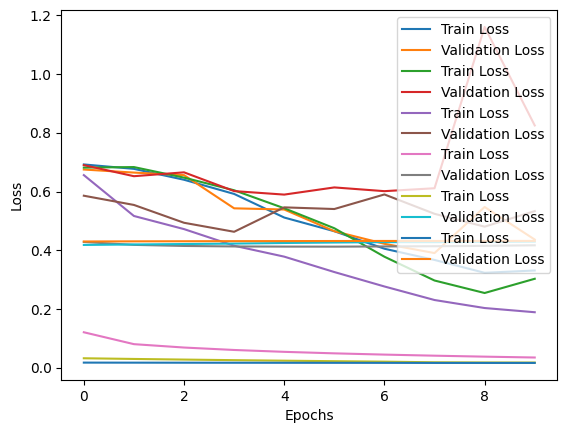

In [18]:
# accuracy display
plt.plot(train_accs, label='Train Accuracy')
plt.plot(vail_accs, label='Validation Accuracy')
plt.plot(two_train_accs, label='TWO Train Accuracy')
plt.plot(two_vail_accs, label='TWO Validation Accuracy')
plt.plot(res_train_accs, label='RES Train Accuracy')
plt.plot(res_vail_accs, label='RES Validation Accuracy')
plt.plot(res50_train_accs, label='RES50 Train Accuracy')
plt.plot(res50_vail_accs, label='RES50 Validation Accuracy')
plt.plot(v2_train_accs, label='V2 Train Accuracy')
plt.plot(v2_vail_accs, label='V2 Validation Accuracy')
plt.plot(vgg16_train_accs, label='VGG16 Train Accuracy')
plt.plot(vgg16_vail_accs, label='VGG16 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# loss fuction display
plt.plot(train_losses, label='Train Loss')
plt.plot(vail_losses, label='Validation Loss')

plt.plot(two_train_losses, label='Train Loss')
plt.plot(two_vail_losses, label='Validation Loss')

plt.plot(res_train_losses, label='Train Loss')
plt.plot(res_vail_losses, label='Validation Loss')

plt.plot(res50_train_losses, label='Train Loss')
plt.plot(res50_vail_losses, label='Validation Loss')

plt.plot(v2_train_losses, label='Train Loss')
plt.plot(v2_vail_losses, label='Validation Loss')

plt.plot(vgg16_train_losses, label='Train Loss')
plt.plot(vgg16_vail_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# save model
# PATH = "Digital.pth"
# torch.save(model.state_dict(), PATH)

In [20]:
"""测试图片"""
total = 0
correct = 0
f1s = []
test_precisions = []
test_recalls = []
test_losses = []
test_accs = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred = model(inputs)
        predicted_probs = F.softmax(pred, dim=1)
        _, predicted = torch.max(pred, 1)

        loss = cross_entropy(pred, labels)  
        test_losses.append(loss.cpu().detach().numpy())
        acc, precision, recall = score(predicted, labels)
        
        f1 = 2 * precision * recall / (precision + recall)
        f1s.append(f1)
        test_precisions.append(precision)
        test_recalls.append(recall)
        test_accs.append(acc)

        total += labels.size(0)
        correct += (predicted == labels).sum()
        
f1_score = sum(f1s)/len(f1s)
loss = sum(test_losses)/len(test_losses)
recall = sum(test_recalls)/len(test_recalls)
precision = sum(test_precisions)/len(test_precisions)
acc = sum(test_accs)/len(test_accs)
print(f"batch:{total}, acc: {acc}, auc: {correct / total * 100}, recall: {recall}, precision: {precision}, f1-score: {f1_score}")

batch:279, acc: 0.7992639675044216, auc: 88.53046417236328, recall: 0.867753161870809, precision: 0.8786659963130551, f1-score: 0.8688239145926968


<Axes: >

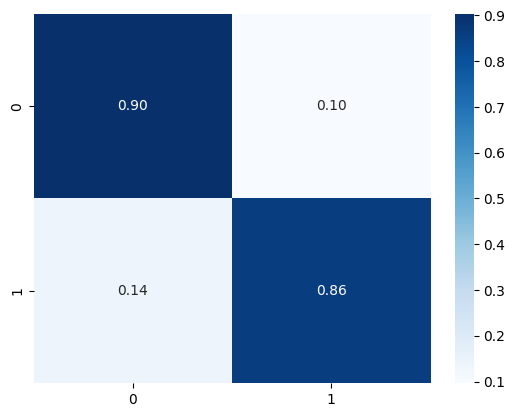

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.cpu().numpy().tolist()


labels = ['0', '1',] 
cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

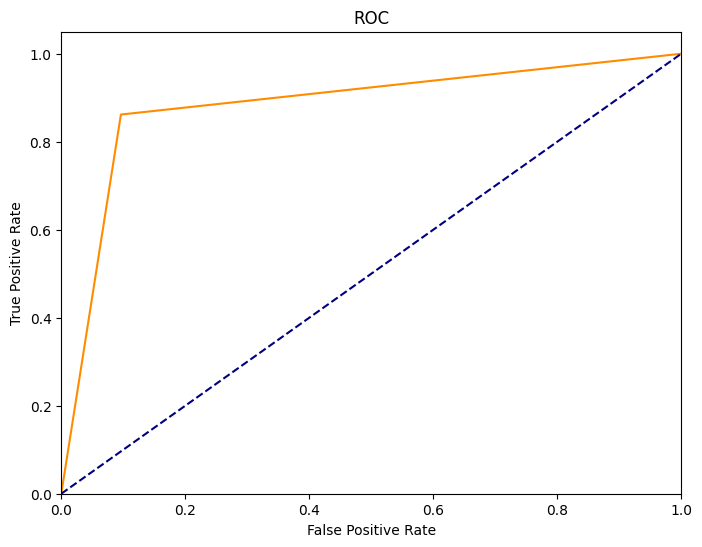

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC ' )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

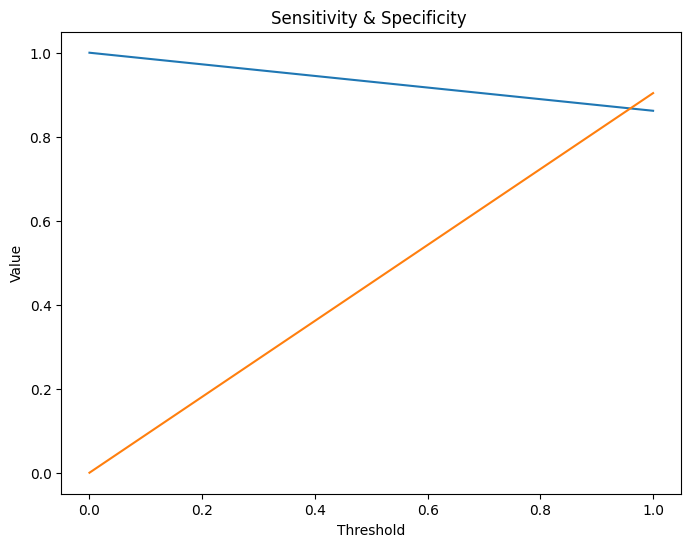

In [23]:

sensitivity = tpr
specificity = 1 - fpr

plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivity, label='Sensitivity')
plt.plot(thresholds, specificity, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Sensitivity & Specificity ')
plt.show()

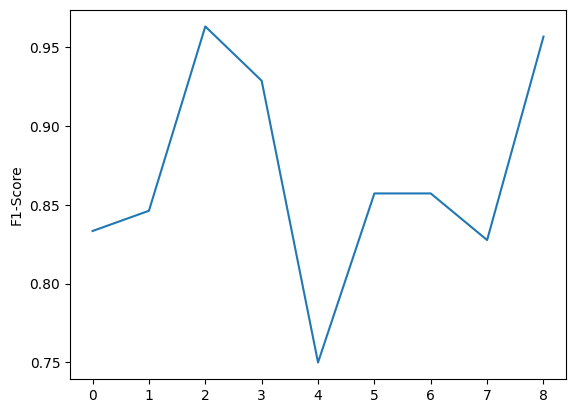

In [24]:

plt.plot(range(len(f1s)), f1s)
plt.ylabel("F1-Score")
plt.show()

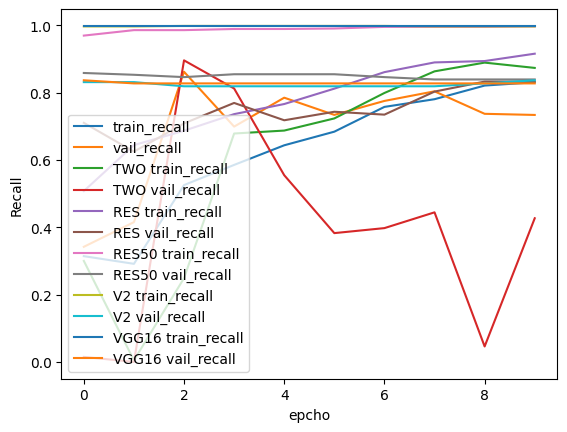

In [25]:

plt.plot(range(len(train_recalls)), train_recalls, label="train_recall")
plt.plot(range(len(vail_recalls)), vail_recalls, label="vail_recall")

plt.plot(range(len(two_train_recalls)), two_train_recalls, label="TWO train_recall")
plt.plot(range(len(two_vail_recalls)), two_vail_recalls, label="TWO vail_recall")

plt.plot(range(len(res_train_recalls)), res_train_recalls, label="RES train_recall")
plt.plot(range(len(res_vail_recalls)), res_vail_recalls, label="RES vail_recall")

plt.plot(range(len(res50_train_recalls)), res50_train_recalls, label="RES50 train_recall")
plt.plot(range(len(res50_vail_recalls)), res50_vail_recalls, label="RES50 vail_recall")

plt.plot(range(len(v2_train_recalls)), v2_train_recalls, label="V2 train_recall")
plt.plot(range(len(v2_vail_recalls)), v2_vail_recalls, label="V2 vail_recall")

plt.plot(range(len(vgg16_train_recalls)), vgg16_train_recalls, label="VGG16 train_recall")
plt.plot(range(len(vgg16_vail_recalls)), vgg16_vail_recalls, label="VGG16 vail_recall")
plt.xlabel("epcho")
plt.ylabel("Recall")
plt.legend(loc="lower left")
plt.show()

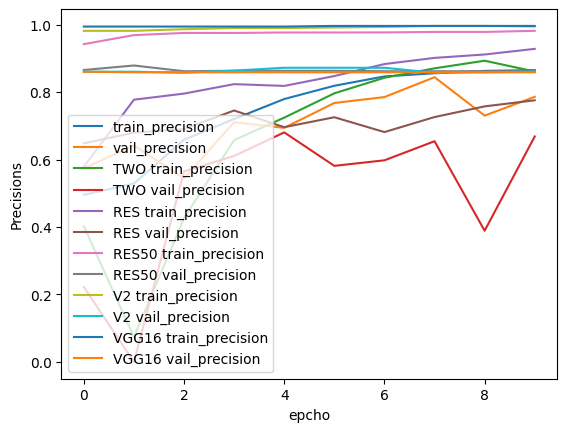

In [26]:

plt.plot(range(len(train_precisions)), train_precisions, label="train_precision")
plt.plot(range(len(vail_precisions)), vail_precisions, label="vail_precision")

plt.plot(range(len(two_train_precisions)), two_train_precisions, label="TWO train_precision")
plt.plot(range(len(two_vail_precisions)), two_vail_precisions, label="TWO vail_precision")

plt.plot(range(len(res_train_precisions)), res_train_precisions, label="RES train_precision")
plt.plot(range(len(res_vail_precisions)), res_vail_precisions, label="RES vail_precision")

plt.plot(range(len(res50_train_precisions)), res50_train_precisions, label="RES50 train_precision")
plt.plot(range(len(res50_vail_precisions)), res50_vail_precisions, label="RES50 vail_precision")

plt.plot(range(len(v2_train_precisions)), v2_train_precisions, label="V2 train_precision")
plt.plot(range(len(v2_vail_precisions)), v2_vail_precisions, label="V2 vail_precision")

plt.plot(range(len(vgg16_train_precisions)), vgg16_train_precisions, label="VGG16 train_precision")
plt.plot(range(len(vgg16_vail_precisions)), vgg16_vail_precisions, label="VGG16 vail_precision")
plt.xlabel("epcho")
plt.ylabel("Precisions")
plt.legend(loc="lower left")
plt.show()

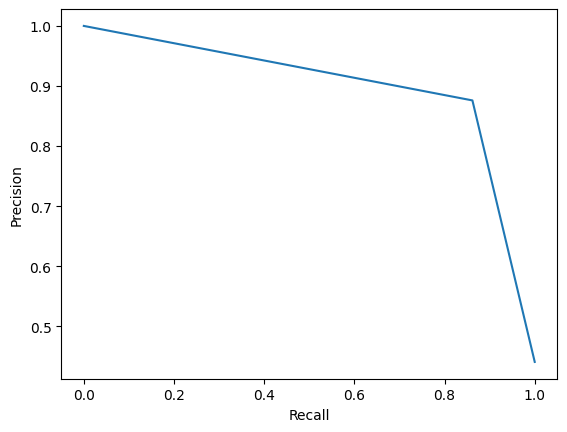

In [27]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# PR
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()